In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

PATH = "../data/CUB_200_2011"

labels = pd.read_csv(os.path.join(PATH, "image_class_labels.txt"), sep=" ", header=None, names=["img_id", "label"])
images = pd.read_csv(os.path.join(PATH, "images.txt"), sep=" ", header=None, names=["img_id", "filepath"])
classes = pd.read_csv(os.path.join(PATH, "classes.txt"), sep=" ", header=None, names=["label", "category"])

df = pd.merge(images, labels, on="img_id")
df = pd.merge(df, classes, on="label")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(PATH, "images"),
    x_col="filepath",
    y_col="category",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(PATH, "images"),
    x_col="filepath",
    y_col="category",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224,224)
)


Found 9430 validated image filenames belonging to 200 classes.
Found 2358 validated image filenames belonging to 200 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning
# for layer in vgg16.layers[:-4]:
#     layer.trainable = False

x = Flatten()(vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dense(200, activation='softmax')(x)
model = Model(inputs=vgg16.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

# Learning Rate Schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train model
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])

# history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[ reduce_lr])
#plot 
plot_accuracy_loss(history)
model.save('../models/vgg16_opt.h5')

#load model
model = load_model('../models/vgg16_opt.h5')

#evaluate
score = model.evaluate(test_generator, steps=50)
print("Test Loss", score[0])
print("Test Accuracy", score[1])

/tmp/ipykernel_2050/1750371047.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])


Epoch 1/100
50/50 [==============================] - 26s 490ms/step - loss: 5.5994 - accuracy: 0.0056 - val_loss: 2180.3169 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 24s 486ms/step - loss: 5.5313 - accuracy: 0.0088 - val_loss: 145.6448 - val_accuracy: 0.0088 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 24s 486ms/step - loss: 5.4628 - accuracy: 0.0075 - val_loss: 138.8109 - val_accuracy: 0.0056 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 24s 487ms/step - loss: 5.4906 - accuracy: 0.0075 - val_loss: 5.3567 - val_accuracy: 0.0063 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 25s 493ms/step - loss: 5.3755 - accuracy: 0.0156 - val_loss: 8.0779 - val_accuracy: 0.0044 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 24s 490ms/step - loss: 5.3427 - accuracy: 0.0100 - val_loss: 40.7182 - val_accuracy: 0.0075 - lr: 0.0010
Epoch 7/100
50/50 [==============================]

KeyboardInterrupt: 

2023-12-15 13:36:43.482305: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 13:36:43.507605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 13:36:43.507666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 13:36:43.510097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 13:36:43.510148: I external/local_xla/xla/stream_executor

Epoch 1/100


/tmp/ipykernel_19804/3903692836.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])
2023-12-15 13:36:47.660121: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-15 13:36:50.721348: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd4327774f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 13:36:50.721383: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-15 13:36:50.724780: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable

50/50 [==============================] - 13s 145ms/step - loss: 5.5671 - accuracy: 0.0069 - val_loss: 7.1995 - val_accuracy: 0.0044 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 5s 108ms/step - loss: 5.5393 - accuracy: 0.0063 - val_loss: 6.2816 - val_accuracy: 0.0037 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 5s 107ms/step - loss: 5.5399 - accuracy: 0.0050 - val_loss: 5.8150 - val_accuracy: 0.0044 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 5s 108ms/step - loss: 5.4238 - accuracy: 0.0075 - val_loss: 11.4065 - val_accuracy: 0.0056 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 5s 105ms/step - loss: 5.4302 - accuracy: 0.0031 - val_loss: 6.6519 - val_accuracy: 0.0081 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 5s 105ms/step - loss: 5.3849 - accuracy: 0.0088 - val_loss: 6.7363 - val_accuracy: 0.0063 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 5s 104ms/step - loss:

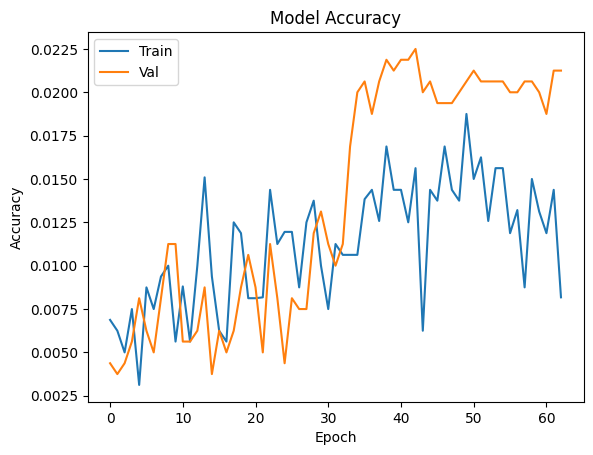

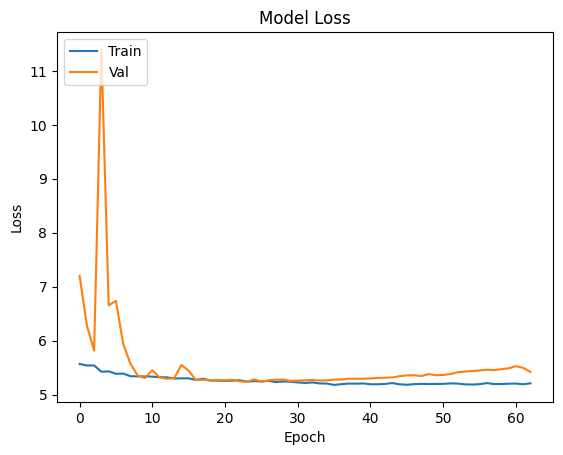

/home/joe/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 3s 52ms/step - loss: 5.4164 - accuracy: 0.0213
Test Loss 5.4164137840271
Test Accuracy 0.021250000223517418


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning
for layer in resnet50.layers[:-10]:#changed from -4
    layer.trainable = False

x = Flatten()(resnet50.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dense(200, activation='softmax')(x)
model = Model(inputs=resnet50.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

# Learning Rate Schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train model
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])

#plot   
plot_accuracy_loss(history)
model.save('../models/resnet50_opt.h5')

#load model
model = load_model('../models/resnet50_opt.h5')

#evaluate
score = model.evaluate(test_generator, steps=50)
print("Test Loss", score[0])
print("Test Accuracy", score[1])

Epoch 1/100


/tmp/ipykernel_23228/3799532975.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])


50/50 [==============================] - 11s 137ms/step - loss: 5.3228 - accuracy: 0.0237 - val_loss: 9.6407 - val_accuracy: 0.0269 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 5s 107ms/step - loss: 4.6080 - accuracy: 0.0800 - val_loss: 5.0560 - val_accuracy: 0.0731 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 5s 106ms/step - loss: 4.1366 - accuracy: 0.1138 - val_loss: 4.5307 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 5s 108ms/step - loss: 3.7894 - accuracy: 0.1688 - val_loss: 4.7998 - val_accuracy: 0.1088 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 5s 103ms/step - loss: 3.4666 - accuracy: 0.2156 - val_loss: 3.2772 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 5s 102ms/step - loss: 3.1462 - accuracy: 0.2744 - val_loss: 2.9276 - val_accuracy: 0.2975 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 5s 108ms/step - loss: 

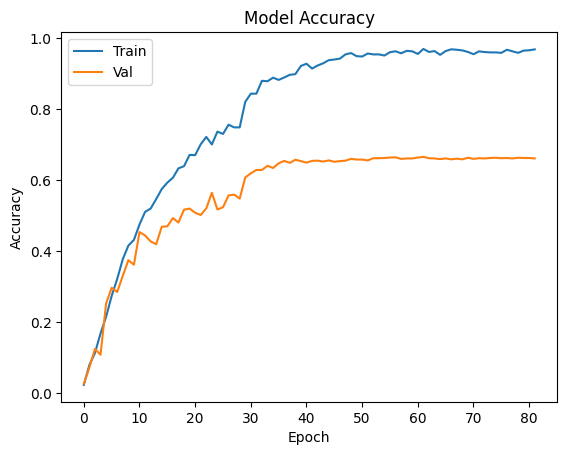

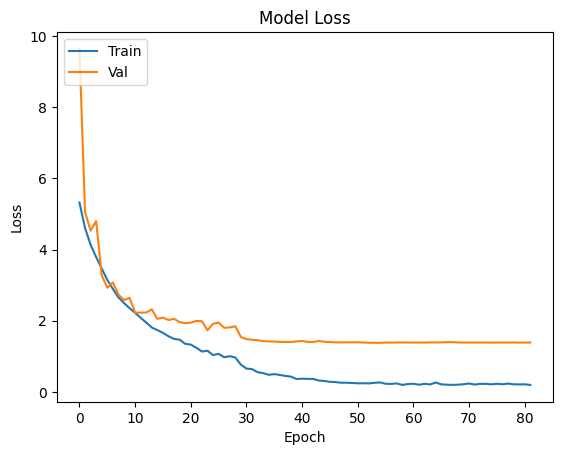

50/50 [==============================] - 3s 52ms/step - loss: 1.3876 - accuracy: 0.6619
Test Loss 1.387619137763977
Test Accuracy 0.6618750095367432


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning
for layer in inceptionv3.layers[:-48]:#-50 gave 65% acc
    layer.trainable = False

x = Flatten()(inceptionv3.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dense(200, activation='softmax')(x)
model = Model(inputs=inceptionv3.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

# Learning Rate Schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train model
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history = model.fit_generator(generator=train_generator, steps_per_epoch=50, epochs=100, validation_data=test_generator, validation_steps=50, callbacks=[early, reduce_lr])

#plot
plot_accuracy_loss(history)
model.save('../models/inceptionv3_opt.h5')

#load model
model = load_model('../models/inceptionv3_opt.h5')

#evaluate
score = model.evaluate(test_generator, steps=50)
print("Test Loss", score[0])
print("Test Accuracy", score[1])